In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    #!git clone https://github.com/mjwock/DeepFLaSH_Pytorch.git /content/drive/My\ Drive/DeepFLaSH_Pytorch/FastAI/
    %cd /content/drive/My\ Drive/DeepFLaSH_Pytorch/FastAI2
    #!git pull
except:
    pass

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/DeepFLaSH_Pytorch/FastAI2


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

!pip install elasticdeform

import pandas as pd

from torch import nn
from sklearn.model_selection import StratifiedKFold

from torchsummary import summary

from deepflash import preproc, unetadaption, utility
from deepflash.fastai_extension import *

import os
from pathlib import Path
#import scipy.io
import matplotlib.pyplot as plt

  Created wheel for elasticdeform: filename=elasticdeform-0.4.6-cp36-cp36m-linux_x86_64.whl size=70429 sha256=2bb3bf9e499be24d87f4ec2459e87d83b8d156445d880e5b51e5a4dac2282cbb
  Stored in directory: /root/.cache/pip/wheels/42/3a/94/a1d69f8b9da44826a171395e67f9f7a117f89af18f206481dd
Successfully built elasticdeform


Using TensorFlow backend.


## Settings

General Params

In [0]:
DIR = '/content/drive/My Drive/DeepFLaSH_Pytorch/FastAI2/data'

IMAGE_COLOR = 'red'   # 'red','green'

TILE_SHAPE = (540,540)    # desired input
PADDING = (184,184)       # 540-356
EL_SIZE = [635.9, 635.9]

SEED = 42

In [0]:
# ONLY CHANGE FOR DIFFERENT FOLDER STRUCTURE
IMG_PATH = f'{DIR}/images/{IMAGE_COLOR}'
MASK_PATH = f'{DIR}/temp_data/labels/'
WEIGHT_PATH = f'{DIR}/temp_data/weights/'

# DON'T CHANGE
MASK_SHAPE = tuple(np.subtract(TILE_SHAPE,PADDING))

Training Params

In [0]:
BATCH_SIZE = 2
EPOCHS = 100
N_SPLITS = 10

Network Params

In [0]:
IN_CHANNELS = 1
N_CLASSES = 2  #number of classes
DEPTH = 5
BATCH_NORM = False

# Custom Net Overview

In [7]:
#GPU Hardware Acceleration needed (cuda)

net = unetadaption.UNet(in_channels=IN_CHANNELS,
                        n_classes=N_CLASSES,
                        depth=DEPTH,
                        batch_norm=BATCH_NORM)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = net.to(device)

summary(model, input_size=(IN_CHANNELS, TILE_SHAPE[0], TILE_SHAPE[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 538, 538]             640
              ReLU-2         [-1, 64, 538, 538]               0
            Conv2d-3         [-1, 64, 536, 536]          36,928
              ReLU-4         [-1, 64, 536, 536]               0
     UNetConvBlock-5         [-1, 64, 536, 536]               0
            Conv2d-6        [-1, 128, 266, 266]          73,856
              ReLU-7        [-1, 128, 266, 266]               0
            Conv2d-8        [-1, 128, 264, 264]         147,584
              ReLU-9        [-1, 128, 264, 264]               0
    UNetConvBlock-10        [-1, 128, 264, 264]               0
           Conv2d-11        [-1, 256, 130, 130]         295,168
             ReLU-12        [-1, 256, 130, 130]               0
           Conv2d-13        [-1, 256, 128, 128]         590,080
             ReLU-14        [-1, 256, 1

## Load Data

Retrieve images from folder

In [0]:
filenames = os.listdir(IMG_PATH)

img_ids = [os.path.splitext(files)[0] for files in filenames] #get list with img_ids
imgExt = os.path.splitext(filenames[0])[1] #get image extension

In [0]:
images = [img_name for img_name in [f'{s}{imgExt}' for s in img_ids]]
img_df = pd.DataFrame([Path(image) for image in images])

Function to map from image path to mask and weight paths

In [0]:
### Change regDigits if filenames have a different structure

regDigits = '\d{4}'
maskExt = '.tif'
get_labels = lambda x: Path(f'{MASK_PATH}/{re.findall(regDigits,Path(x).stem)[0]}{maskExt}')
get_weights = lambda x: Path(f'{WEIGHT_PATH}/{re.findall(regDigits,Path(x).stem)[0]}{maskExt}')

Show example image, labels and weights

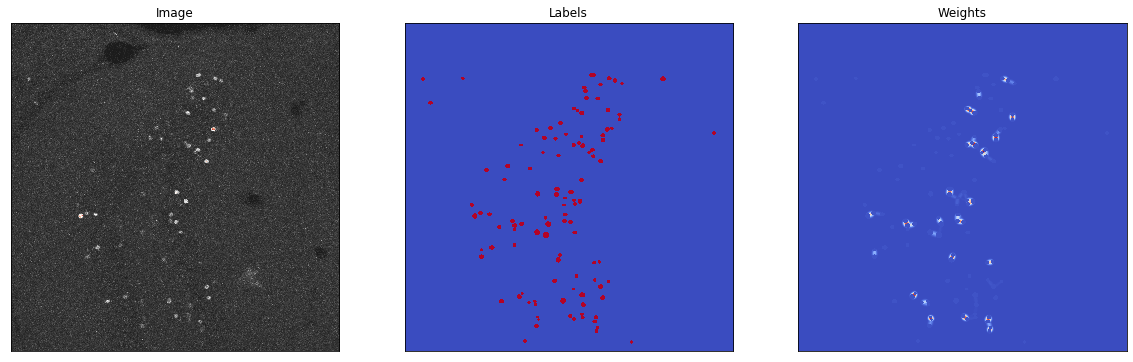

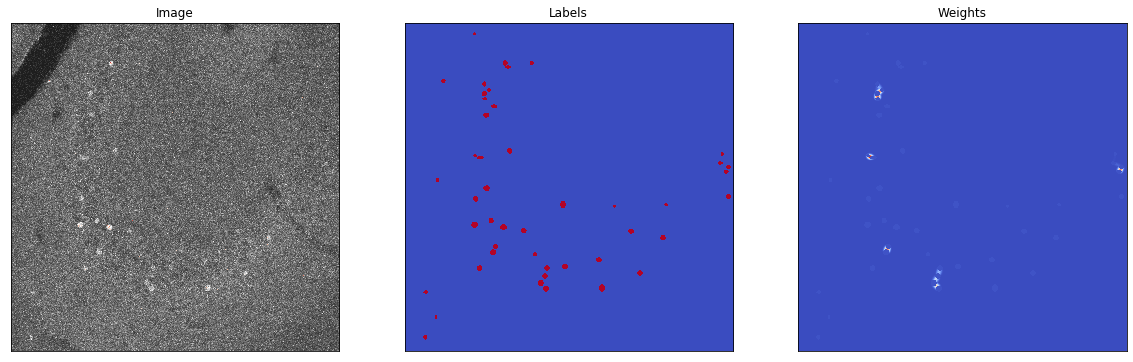

In [11]:
# cmap can be either string or list of strings
utility.show_example_data_batch(IMG_PATH,img_df,get_labels,get_weights,cmap=('RdGy_r','coolwarm','coolwarm'), n=2)

# Create Databunch object for further training

Custom 'get_transforms()' function for selected augmentations

In [0]:
tfms = get_custom_transforms()
#tfms = None                      ####### Pixelwerte für Labels [0,1] verändern sich auch bei tfms = None

Create databunch object

In [13]:
src = (CustomSegmentationItemList.from_df(img_df,IMG_PATH, convert_mode='L')
      # import from df in greyscale ('L')
      .split_by_rand_pct(valid_pct=(1/N_SPLITS))
      # 1/10 train/validation split
      .label_from_funcs(get_labels, get_weights, target_size=MASK_SHAPE, classes = array(['background','cell']))
      # segmentation labels and weights
)

data = (src.transform(tfms=tfms, tfm_y=True, resize_method=ResizeMethod.CROP,size=TILE_SHAPE)
        # apply data augmentation
        .databunch(bs=BATCH_SIZE)
        # set batchsize
)

Masks will be cropped to (356, 356). Choose 'None' to keep initial size.
Masks will be cropped to (356, 356). Choose 'None' to keep initial size.


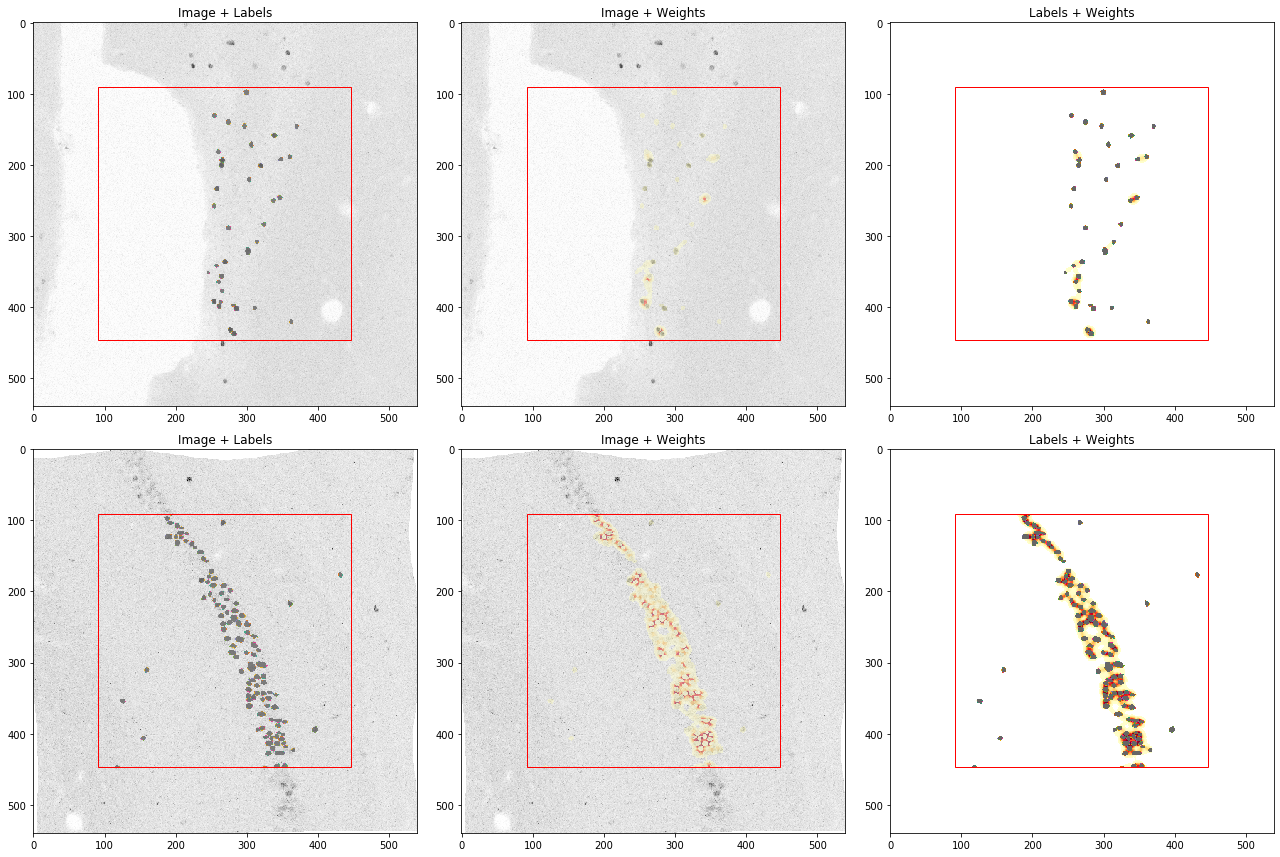

In [14]:
data.show_batch()

**Train**

Metrics

In [0]:
# loss_wrapper let's you use any metric for this weighted-labels architecture 
# (get's rid of the weights and passes only labels to loss func)
# if 'swap_preds = True' inputs are swapped (useful for sklearn.metrics)

IoU = loss_wrapper(metric=dice, iou=True)
f1 = loss_wrapper(metric=fbeta, beta=1)

Learner

In [0]:
learn = Learner(data, 
                net,
                model_dir = DIR,
                opt_func = torch.optim.Adam,
                metrics = [IoU,f1],
                loss_func = WeightedCrossEntropyLoss(axis=1, reduction_mode='sum'),
                wd=0.05)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


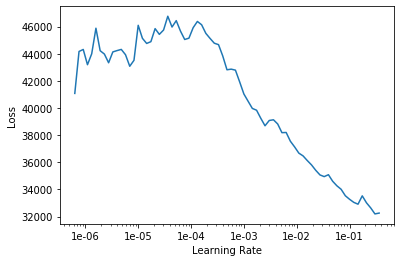

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(20,max_lr=5e-3)

epoch,train_loss,valid_loss,dice,fbeta,time
0,36462.000000,18792.134766,0.000000,0.027865,00:13
1,30291.251953,18792.134766,0.000000,0.027865,00:10
2,28509.798828,18792.134766,0.000000,0.027865,00:10
3,27747.777344,18792.134766,0.000000,0.027865,00:10
4,27542.314453,18792.134766,0.000000,0.027865,00:13
5,27412.455078,18792.134766,0.000000,0.027865,00:11
6,27022.683594,18792.134766,0.000000,0.027865,00:10
7,26928.794922,18792.134766,0.000000,0.027865,00:11
8,26863.341797,18792.134766,0.000000,0.027865,00:10
9,26839.152344,18792.134766,0.000000,0.027865,00:11


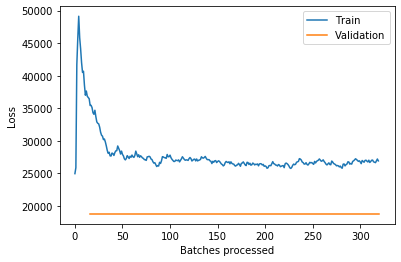

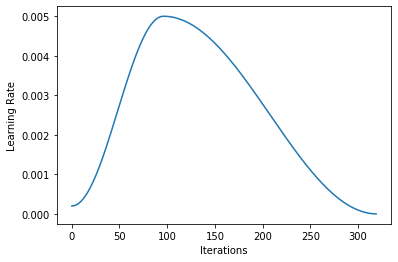

In [19]:
learn.recorder.plot_losses()
learn.recorder.plot_lr()

In [0]:
#skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=1)